<a href="https://colab.research.google.com/github/szymonpetranowicz/SNN-cover-art-archive-calssification/blob/main/SNN_cover_art_archive_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Short summary

This notebook has been written as a technical part of my master's degree diploma project, about Siamese Neural Networks with triplet loss function.

The analysis is based on 10k vinyl covert art. The core goal was to train SNN to check whether cover art is in the collection.

The analysis contains 108 resnet_v2 models in a combination of:

- image preprocessing [resnet preprocess, diy preprocess]
- version of the model [50,101,152]
- epoch [1,3,5]
- triplet per image [1,10]


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import plotly.graph_objs as go
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications, optimizers, metrics, Model
from tensorflow.keras.layers import Dense, Input

In [ ]:
START = 0
SAMPLES = 300

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/mgr/1.zip" -d "/content/test"

In [ ]:
directory_path = '/content/test/'
archive_id = os.listdir(directory_path)
archive_id.sort()

In [ ]:
class TripletLoss:

    def embedding(self,activation,resnet_version):
      if activation != '':
        model = tf.keras.Sequential([
        hub.KerasLayer(f"https://tfhub.dev/google/imagenet/resnet_v2_{resnet_version}/feature_vector/5",
                      trainable=False, name = 'Embedding'),  # Can be True, see below.

              Dense(SAMPLES, activation=activation)])

      else:
              model = tf.keras.Sequential([
              hub.KerasLayer(f"https://tfhub.dev/google/imagenet/resnet_v2_{resnet_version}/feature_vector/5",
                            trainable=False, name = 'Embedding'),  # Can be True, see below.

                    Dense(SAMPLES)])

      model.build([None, 224, 224, 3])  # Batch input shape.

      return model


In [ ]:
class DistanceLayer(Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """


    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.9):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):

        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):

        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # List metrics here so the `reset_states()` can be called automatically.
        return [self.loss_tracker]

In [ ]:
def train_datagen_resnet():
   train_datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.2,
      # rescale = 1./255,
      brightness_range = (0.8,1.2))
   return train_datagen

In [ ]:
def train_datagen_func():
   train_datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.2,
      rescale = 1./255,
      brightness_range = (0.8,1.2)
      )
   return train_datagen

In [ ]:
def preprocess_resnet(directory_path,K,archive_id,index):

  train_datagen = train_datagen_resnet()

  img = archive_id[index]
  image_path = directory_path + img

  raw_image = tf.image.decode_png(tf.io.read_file(image_path))
  raw_image = np.expand_dims(raw_image,0)


  anchor = tf.keras.applications.resnet_v2.preprocess_input(
      raw_image)

  anchors = np.array([anchor[0] for x in range(K)])
  positives = train_datagen.flow(raw_image)
  positives = np.array([tf.keras.applications.resnet_v2.preprocess_input(next(positives)[0]) for x in range(K)])

  random_negatives = archive_id.copy()
  random_negatives.remove(img)
  random_negatives = random.choices(random_negatives,k=K)

  negatives = [np.expand_dims(tf.image.decode_png(tf.io.read_file(directory_path+random_negative)),0)[0] for random_negative in random_negatives]
  negatives = np.array([tf.keras.applications.resnet_v2.preprocess_input(negative) for negative in negatives])

  return anchors,positives,negatives

In [ ]:
def preprocess_diy(directory_path,K,archive_id,index):

  train_datagen = train_datagen_func()

  img = archive_id[index]
  image_path = directory_path + img
  raw_image = Image.open(image_path)
  raw_image = np.expand_dims(raw_image,0)

  anchors = [tf.convert_to_tensor(raw_image[0],dtype=tf.float32)/255.0 for x in range(K)]

  positives = train_datagen.flow(raw_image)
  positives = [next(positives)[0] for x in range(K)]

  random_negatives = archive_id.copy()
  random_negatives.remove(img)
  random_negatives = random.choices(random_negatives,k=K)

  negatives = [tf.convert_to_tensor(Image.open(directory_path+sample),dtype=tf.float32)/255.0 for sample in random_negatives]


  return anchors,positives,negatives

In [ ]:
def dataset_maker(prep,k):
  print(f'Making dataset for k == {k}, resnet preprocessing: {prep}')
  if prep == True:
    anchor,positive,negative = preprocess_resnet(directory_path,k,archive_id,START)
  elif prep == False:
    anchor,positive,negative = preprocess_diy(directory_path,k,archive_id,START)

  anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor)
  positive_dataset = tf.data.Dataset.from_tensor_slices(positive)
  negative_dataset = tf.data.Dataset.from_tensor_slices(negative)

  for i in range(START+1,SAMPLES+START):
    if prep == True:
      anchor,positive,negative = preprocess_resnet(directory_path,k,archive_id,i)
    elif prep == False:
      anchor,positive,negative = preprocess_diy(directory_path,k,archive_id,i)

    anchor_dataset_to_concat = tf.data.Dataset.from_tensor_slices(anchor)
    positive_dataset_to_concat = tf.data.Dataset.from_tensor_slices(positive)
    negative_dataset_to_concat = tf.data.Dataset.from_tensor_slices(negative)

    anchor_dataset = anchor_dataset.concatenate(anchor_dataset_to_concat)
    positive_dataset = positive_dataset.concatenate(positive_dataset_to_concat)
    negative_dataset = negative_dataset.concatenate(negative_dataset_to_concat)

    del anchor_dataset_to_concat,positive_dataset_to_concat,negative_dataset_to_concat

    if i%50 == 0:
      print('Iteration:',i)
    elif i == SAMPLES + START -1:
      print('Done')

  dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))

  data = dataset.shuffle(1000)

  train_dataset = data.take(round(len(data)*.7))
  train_dataset = train_dataset.batch(16)
  train_dataset = train_dataset.prefetch(8)

  val_dataset = data.skip(round(len(data)*.7))
  val_dataset = val_dataset.take(round(len(data)*.3))
  val_dataset = val_dataset.batch(16)
  val_dataset = val_dataset.prefetch(8)
  return train_dataset, val_dataset

In [ ]:
def training(model_version,activation,train_dataset,val_dataset,epoch,test_group,model_directory):
  print(f"""Start training
            Resnet version: {model_version}
            Samples: {SAMPLES}
            Triplets per sample: {k}
            Epochs: {epoch}
            Preprocessing: {prep}
            Activation: {activation}""")

  model = TripletLoss()
  embedding = model.embedding(activation,model_version)
  target_shape = (224,224)

  # Setup Network
  anchor_input = Input(name="anchor", shape=target_shape + (3,))
  positive_input = Input(name="positive", shape=target_shape + (3,))
  negative_input = Input(name="negative", shape=target_shape + (3,))

  distances = DistanceLayer()(
      embedding(anchor_input),
      embedding(positive_input),
      embedding(negative_input),
  )

  siamese_network = Model(
      inputs=[anchor_input, positive_input, negative_input], outputs=distances
  )
  if START > 0:
    load_group = test_group.split('_')[:-1]
    trained_samples = [str(int(test_group.split('_')[-1])-SAMPLES)]
    load_group = '_'.join(load_group+trained_samples)
    embedding.load_weights(f'{model_directory}/{load_group}.h5')
    print(f'Embedded loaded: {load_group}')

  siamese_model = SiameseModel(siamese_network)
  siamese_model.compile(optimizer=optimizers.Adam(0.0001),
                        weighted_metrics =['accuracy'])

  history = siamese_model.fit(train_dataset, epochs=epoch, validation_data=val_dataset)

  # save the weights
  print(f'Saving the model:{test_group}')
  model_h5_path = f'{model_directory}/{test_group}.h5'
  embedding.save_weights(model_h5_path)
  print('Model saved.')
  # clear_output()
  return history

In [ ]:
def preprocess_augmented_resnet(directory_path,test,index):

  train_datagen = train_datagen_resnet()
  img = test[index]
  image_path = directory_path + img
  raw_image = tf.image.decode_png(tf.io.read_file(image_path))
  raw_image = np.expand_dims(raw_image,0)
  augmented = train_datagen.flow(raw_image)
  augmented = tf.keras.applications.resnet_v2.preprocess_input(next(augmented)[0], data_format=None)
  augmented = np.expand_dims(augmented,0)

  return augmented

In [ ]:
def preprocess_anchor_resnet(directory_path,test,index):

  img = test[index]
  image_path = directory_path + img
  raw_image = tf.image.decode_png(tf.io.read_file(image_path))
  raw_image = np.expand_dims(raw_image,0)

  anchor = tf.keras.applications.resnet_v2.preprocess_input(raw_image, data_format=None)

  return anchor

In [ ]:
def preprocess_anchor_func(directory_path,test,index):

  img = test[index]
  image_path = directory_path + img
  raw_image = Image.open(image_path)
  raw_image= tf.convert_to_tensor(raw_image,dtype=tf.float32)/255.0
  raw_image = np.expand_dims(raw_image,0)

  return raw_image

In [ ]:
def preprocess_augmented_func(directory_path,test,index):
  train_datagen = train_datagen_func()
  img = test[index]
  image_path = directory_path + img
  raw_image = Image.open(image_path)
  raw_image = np.expand_dims(raw_image,0)
  augmented = train_datagen.flow(raw_image)
  augmented = next(augmented)[0]

  return np.expand_dims(augmented,0)

In [ ]:
models = [
          '50',
          '50_softmax',
          '50_preprocess',
          '50_softmax_preprocess',
          '50_sigmoid',
          '50_sigmoid_preprocess',
          '101',
          '101_softmax',
          '101_preprocess',
          '101_softmax_preprocess',
          '101_sigmoid',
          '101_sigmoid_preprocess',
          '152',
          '152_softmax',
          '152_preprocess',
          '152_softmax_preprocess',
          '152_sigmoid',
          '152_sigmoid_preprocess',
          ]

k_list = [1,10]
epoch_list = [1,3,5]


In [ ]:
k_list = [1,10]
epoch_list = [1,3,5]

In [ ]:
def comparison(test_1,test_2):

  cosine_similarity = metrics.CosineSimilarity()
  similarity = cosine_similarity(embedding(test_1),embedding(test_2))

  return similarity.numpy()

# Training loop

In [ ]:
model_directory = '/content/gdrive/MyDrive/mgr/model_comparison'
history_comparison = {}
for k in k_list:
  # preparing datasets, one preprocess one not
  train_dataset_prep, val_dataset_prep = dataset_maker(True,k)
  train_dataset, val_dataset = dataset_maker(False,k)
  for model in models:
    # if preprocess - select proprer dataset, selecting version of the model, if softmax - setting activation function
        test_group = model.split('_')
        model_version = test_group[0]

        if 'preprocess' in test_group:
            preprocess = 'preprocess'
        else:
            preprocess = ''

        if 'softmax' in test_group:
            activation = 'softmax'
        elif 'sigmoid' in test_group:
            activation = 'sigmoid'
        else:
          activation = ''

        for epoch in epoch_list:
          # training
           test_group = ('_'.join(list(filter(None,[model_version,activation,preprocess,str(k),str(epoch)]))))
           if prep == 'preprocess':
            history_comparison[test_group] = training(model_version,activation,train_dataset_prep,val_dataset_prep,epoch,test_group,model_directory).history
           elif prep == '':
            history_comparison[test_group] = training(model_version,activation,train_dataset,val_dataset,epoch,test_group,model_directory).history



Making dataset for k == 1, resnet preprocessing: True
Iteration: 50
Iteration: 100
Iteration: 150
Iteration: 200
Iteration: 250
Done
Making dataset for k == 1, resnet preprocessing: False
Iteration: 50
Iteration: 100
Iteration: 150
Iteration: 200
Iteration: 250
Done
Start training
            Resnet version: 50
            Samples: 300
            Triplets per sample: 1
            Epochs: 1
            Preprocessing: False
            Activation: 
14/14 [==============================] - 7s 208ms/step - loss: 23.6189 - val_loss: 8.7677
Saving the model:50_1_1
Model saved.
Start training
            Resnet version: 50
            Samples: 300
            Triplets per sample: 1
            Epochs: 3
            Preprocessing: False
            Activation: 
Epoch 1/3
14/14 [==============================] - 7s 152ms/step - loss: 18.8893 - val_loss: 10.0427
Epoch 2/3
14/14 [==============================] - 1s 74ms/step - loss: 8.6728 - val_loss: 7.0171
Epoch 3/3
14/14 [==================

In [ ]:
history_df = pd.DataFrame(history_comparison)

In [ ]:
history_df = history_df.T

In [ ]:
history_df.to_excel('/content/gdrive/MyDrive/mgr/data_comparison/history.xlsx')

In [ ]:
def preprocess_for_test_img(image_path,prep):
  if prep == True:
    raw_image = np.expand_dims(tf.image.decode_png(tf.io.read_file(image_path)),0)
    preprocessed_resnet = tf.keras.applications.resnet_v2.preprocess_input(
        raw_image, data_format=None
    )
    return preprocessed_resnet
  elif prep == False:
    preprocessed = np.expand_dims(tf.convert_to_tensor(Image.open(image_path),dtype=tf.float32)/255.0,0)
    return preprocessed

In [ ]:
image_path = '/content/gdrive/MyDrive/mgr/test_img/1.png'
test_1_resnet = preprocess_for_test_img(image_path,True)
test_1 = preprocess_for_test_img(image_path,False)

# Image preprocessed by resnet preprocessing function

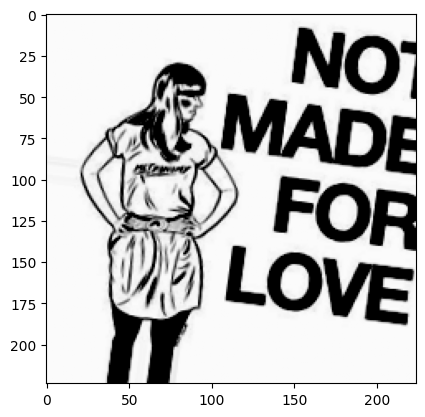

In [ ]:
plt.imshow(test_1_resnet[0])

# Image prerpocessed by diy function

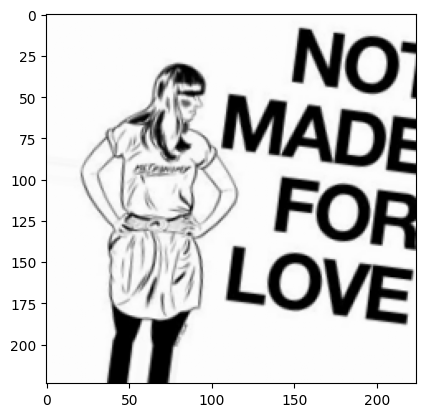

In [ ]:
plt.imshow(test_1[0])

In [ ]:
# Image.fromarray(preprocess_augmented_func(directory_path,test,5456)[0].astype(np.uint8)).save('/content/gdrive/MyDrive/model/test_img/5456.png')

# Test loop


In [ ]:
len(os.listdir('/content/gdrive/MyDrive/mgr/model_comparison'))

108

In [ ]:
test_comparison = {}

for model in models:
  test_comparison[model] = {}

In [ ]:
test_comparison

{'50': {},
 '50_softmax': {},
 '50_preprocess': {},
 '50_softmax_preprocess': {},
 '50_sigmoid': {},
 '50_sigmoid_preprocess': {},
 '101': {},
 '101_softmax': {},
 '101_preprocess': {},
 '101_softmax_preprocess': {},
 '101_sigmoid': {},
 '101_sigmoid_preprocess': {},
 '152': {},
 '152_softmax': {},
 '152_preprocess': {},
 '152_softmax_preprocess': {},
 '152_sigmoid': {},
 '152_sigmoid_preprocess': {}}

In [ ]:
image_path = '/content/gdrive/MyDrive/mgr/test_img/1.png'
test_1_resnet = preprocess_for_test_img(image_path,True)
test_1 = preprocess_for_test_img(image_path,False)

model_dir = '/content/gdrive/MyDrive/mgr/model_comparison'

for model in os.listdir(model_dir):
  test_group = model.split('_')
  model_version = test_group[0]

  if 'preprocess' in test_group:
      preprocess = 'preprocess'
  else:
      preprocess = ''

  if 'softmax' in test_group:
      activation = 'softmax'
  elif 'sigmoid' in test_group:
      activation = 'sigmoid'
  else:
    activation = ''
  test_comparison_id = '_'.join(list(filter(None,[model_version,activation,preprocess])))
  test_group = '_'.join(test_group)
  test_sample = test_group.split(test_comparison_id+'_')[1]


  test_comparison[test_comparison_id][test_sample] = []
  model = TripletLoss()
  embedding = model.embedding(activation,model_version)
  embedding.load_weights(f'{model_dir}/{test_group}.h5')
  print(test_group)
  if preprocess == 'preprocess':
    for img in range(100):
      image_path = directory_path + archive_id[img]
      test_2 = preprocess_for_test_img(image_path,True)
      test_comparison[test_comparison_id][test_sample].append(comparison(test_1_resnet,test_2))
  elif preprocess == '':
    for img in range(100):
      image_path = directory_path + archive_id[img]
      test_2 = preprocess_for_test_img(image_path,False)
      test_comparison[test_comparison_id][test_sample].append(comparison(test_1,test_2))


50_1_1
50_1_3
50_1_5
50_softmax_1_1
50_softmax_1_3
50_softmax_1_5
50_preprocess_1_1
50_preprocess_1_3
50_preprocess_1_5
50_softmax_preprocess_1_1
50_softmax_preprocess_1_3
50_softmax_preprocess_1_5
50_sigmoid_1_1
50_sigmoid_1_3
50_sigmoid_1_5
50_sigmoid_preprocess_1_1
50_sigmoid_preprocess_1_3
50_sigmoid_preprocess_1_5
101_1_1
101_1_3
101_1_5
101_softmax_1_1
101_softmax_1_3
101_softmax_1_5
101_preprocess_1_1
101_preprocess_1_3
101_preprocess_1_5
101_softmax_preprocess_1_1
101_softmax_preprocess_1_3
101_softmax_preprocess_1_5
101_sigmoid_1_1
101_sigmoid_1_3
101_sigmoid_1_5
101_sigmoid_preprocess_1_1
101_sigmoid_preprocess_1_3
101_sigmoid_preprocess_1_5
152_1_1
152_1_3
152_1_5
152_softmax_1_1
152_softmax_1_3
152_softmax_1_5
152_preprocess_1_1
152_preprocess_1_3
152_preprocess_1_5
152_softmax_preprocess_1_1
152_softmax_preprocess_1_3
152_softmax_preprocess_1_5
152_sigmoid_1_1
152_sigmoid_1_3
152_sigmoid_1_5
152_sigmoid_preprocess_1_1
152_sigmoid_preprocess_1_3
152_sigmoid_preprocess_1_5
5

#Analysis

In [ ]:
import plotly.graph_objs as go
import plotly.express as px

In [ ]:
df = pd.DataFrame(test_comparison)

In [ ]:
test_comparison = df

In [ ]:
df.to_excel('/content/gdrive/MyDrive/mgr/data_comparison/trained_1_without_activation_during_verification.xlsx')

In [ ]:
test_comparison =  pd.read_excel('/content/gdrive/MyDrive/mgr/data_comparison/trained_1.xlsx')

In [ ]:
test_comparison = test_comparison.rename(columns={'Unnamed: 0' : 'sample'}).set_index('sample')

In [ ]:
selected_data = pd.DataFrame(columns = test_comparison.columns, index = test_comparison.index)

In [ ]:
rejected_data = pd.DataFrame(columns = test_comparison.columns, index = test_comparison.index)

In [ ]:
for column in test_comparison:
  for idx in test_comparison[column].index:
    if type(test_comparison[column][idx]) == type('string'):
      test_comparison[column][idx] = np.array([float(x) for x in test_comparison[column][idx][1:-1].split(',')])

In [ ]:
for column in test_comparison:
  for idx in test_comparison[column].index:
    if type(test_comparison[column][idx]) == type(np.array([])):
      if test_comparison[column][idx].max() == test_comparison[column][idx][0]:
        selected_data[column][idx] =  test_comparison[column][idx]
      else:
        rejected_data[column][idx] =  test_comparison[column][idx]

In [ ]:
selected_data = selected_data.fillna('na')

In [ ]:
rejected_data = rejected_data.fillna('na')

In [ ]:
test_comparison = test_comparison.fillna(0)

In [ ]:
selected_data

,50,50_softmax,50_preprocess,50_softmax_preprocess,50_sigmoid,50_sigmoid_preprocess,101,101_softmax,101_preprocess,101_softmax_preprocess,101_sigmoid,101_sigmoid_preprocess,152,152_softmax,152_preprocess,152_softmax_preprocess,152_sigmoid,152_sigmoid_preprocess
sample,,,,,,,,,,,,,,,,,,
1_1,"[0.863485, 0.319886, 0.23214988, 0.3980221, 0....","[0.9007846, 0.46131033, 0.4044159, 0.5281708, ...","[0.9588491, 0.77959156, 0.88127416, 0.8097313,...",na,"[0.8539868, 0.28096643, 0.2503156, 0.31221238,...","[0.9731639, 0.8469749, 0.92072296, 0.86670506,...","[0.8446598, 0.41865304, 0.33065626, 0.47501594...","[0.8901079, 0.5592984, 0.44397268, 0.5791526, ...",na,na,"[0.83164585, 0.4229825, 0.24980745, 0.34416124...",na,"[0.78111076, 0.40146428, 0.16263351, 0.3180599...","[0.8376387, 0.45827454, 0.39407742, 0.4715091,...","[0.93637145, 0.8310716, 0.775278, 0.6957596, 0...","[0.9381024, 0.8440933, 0.7650781, 0.7202272, 0...","[0.80534637, 0.38714996, 0.39725915, 0.3468632...","[0.954842, 0.8925364, 0.83651274, 0.8107292, 0..."
1_3,"[0.84191376, 0.37489775, 0.23987919, 0.4097377...","[0.95162034, 0.7841005, 0.74773234, 0.8087213,...","[0.94070804, 0.6732797, 0.7761376, 0.6892458, ...","[0.9666264, 0.83293223, 0.8912319, 0.85073316,...","[0.84367305, 0.36448023, 0.17737418, 0.4086313...","[0.97191226, 0.8692812, 0.91915494, 0.86867994...","[0.86205053, 0.34523946, 0.31160098, 0.3994416...","[0.94963145, 0.81266856, 0.7264153, 0.8464266,...",na,na,"[0.83765745, 0.36048123, 0.22569132, 0.4063957...",na,"[0.81350935, 0.32171416, 0.31591642, 0.3073663...","[0.92751855, 0.78731114, 0.77098405, 0.8031909...","[0.9279499, 0.83166033, 0.70102626, 0.62794685...","[0.9735162, 0.9437001, 0.89510524, 0.88823, 0....","[0.78476363, 0.3619406, 0.2476648, 0.3045411, ...","[0.9613152, 0.91677344, 0.8466813, 0.80861557,..."
1_5,"[0.84975785, 0.30751717, 0.2789058, 0.48032472...","[0.9811527, 0.8982234, 0.8985257, 0.9285855, 0...","[0.9320023, 0.6496859, 0.7557583, 0.6750785, 0...","[0.9659119, 0.80350125, 0.8948092, 0.8307343, ...","[0.85235965, 0.3437118, 0.2403274, 0.393147, 0...","[0.97525394, 0.87551653, 0.9283881, 0.89000165...","[0.84181005, 0.39796427, 0.20893723, 0.3809963...","[0.97586477, 0.91357803, 0.877304, 0.9298098, ...","[0.90217227, 0.74590653, 0.77165455, 0.686873,...",na,"[0.8412729, 0.4653586, 0.30974767, 0.46919447,...",na,"[0.80268663, 0.4594057, 0.2936474, 0.33904862,...","[0.97064346, 0.91379887, 0.88186353, 0.906245,...","[0.90596235, 0.8424993, 0.67534435, 0.59030354...","[0.9881602, 0.97322816, 0.9513705, 0.962551, 0...","[0.76914835, 0.34818324, 0.35451078, 0.2344679...","[0.9593196, 0.8894286, 0.8490385, 0.8324499, 0..."
10_1,"[0.87527704, 0.2513211, 0.25717065, 0.45233497...","[0.98612064, 0.94903636, 0.94266856, 0.9521416...","[0.92035955, 0.7222146, 0.718569, 0.5222155, 0...","[0.9932305, 0.96112096, 0.9754336, 0.96294713,...","[0.860595, 0.36654916, 0.29216722, 0.37692928,...","[0.97434723, 0.8939322, 0.9097949, 0.8704556, ...","[0.8666371, 0.47602433, 0.32902154, 0.4795323,...","[0.98739374, 0.94930094, 0.9229292, 0.9577724,...",na,na,"[0.86386096, 0.4544654, 0.32399932, 0.44801965...",na,"[0.7420624, 0.32346925, 0.19802205, 0.3005894,...","[0.9840052, 0.9457713, 0.9352325, 0.9411429, 0...","[0.9283946, 0.8082158, 0.6984654, 0.5754482, 0...","[0.98936313, 0.97594106, 0.95177025, 0.9578477...","[0.76689, 0.34654424, 0.16353273, 0.26013285, ...","[0.9706647, 0.9112206, 0.8834318, 0.88019145, ..."
10_3,"[0.8519844, 0.32978803, 0.23279324, 0.3269432,...","[0.9934966, 0.97334886, 0.9623088, 0.9750267, ...","[0.9225237, 0.7153026, 0.683211, 0.4501319, 0....","[0.9959966, 0.97453594, 0.98576415, 0.9807645,...","[0.8755497, 0.32742882, 0.25390548, 0.5323155,...","[0.97785455, 0.9220549, 0.93018603, 0.89343524...","[0.8696491, 0.46320572, 0.2814618, 0.39790633,...","[0.9942029, 0.97598255, 0.9602273, 0.9815092, ...","[0.88425744, 0.6743216, 0.70045894, 0.6448561,...","[0.99503493, 0.9719385, 0.9887724, 0.9731865, ...","[0.8705902, 0.

In [ ]:
rejected_data

,50,50_softmax,50_preprocess,50_softmax_preprocess,50_sigmoid,50_sigmoid_preprocess,101,101_softmax,101_preprocess,101_softmax_preprocess,101_sigmoid,101_sigmoid_preprocess,152,152_softmax,152_preprocess,152_softmax_preprocess,152_sigmoid,152_sigmoid_preprocess
sample,,,,,,,,,,,,,,,,,,
1_1,na,na,na,"[0.96039766, 0.81093, 0.9004442, 0.8217498, 0....",na,na,na,na,"[0.9359538, 0.7793677, 0.8744153, 0.75353444, ...","[0.96282643, 0.854736, 0.92725325, 0.8377648, ...",na,"[0.96045065, 0.84875965, 0.9270647, 0.8038711,...",na,na,na,na,na,na
1_3,na,na,na,na,na,na,na,na,"[0.9164574, 0.7037805, 0.8346591, 0.6799555, 0...","[0.9716525, 0.9105917, 0.9568862, 0.8932903, 0...",na,"[0.96089816, 0.82892364, 0.9328233, 0.8253143,...",na,na,na,na,na,na
1_5,na,na,na,na,na,na,na,na,na,"[0.987586, 0.949979, 0.978954, 0.94790834, 0.9...",na,"[0.97440505, 0.90488404, 0.95666206, 0.8705801...",na,na,na,na,na,na
10_1,na,na,na,na,na,na,na,na,"[0.903777, 0.65306723, 0.8024715, 0.7225007, 0...","[0.9800237, 0.8779068, 0.9540786, 0.8966448, 0...",na,"[0.9675119, 0.88908273, 0.9511828, 0.85096353,...",na,na,na,na,na,na
10_3,na,na,na,na,na,na,na,na,na,na,na,"[0.9774678, 0.9210343, 0.9551551, 0.87724507, ...",na,na,na,na,na,na
10_5,na,na,na,na,na,"[0.9736706, 0.9037821, 0.9247674, 0.855192, 0....",na,na,na,"[0.99623424, 0.9812232, 0.9927057, 0.9793717, ...",na,"[0.9750025, 0.93468666, 0.9496976, 0.9005222, ...",na,na,na,na,na,na


In [ ]:
rejected = set()
data = rejected_data
for column in data:
  for idx in data[column].index:
    if type(data[column][idx]) != type('na'):
      rejected.add(f'{column}_{idx}')

In [ ]:
rejected

{'101_preprocess_10_1',
 '101_preprocess_1_1',
 '101_preprocess_1_3',
 '101_sigmoid_preprocess_10_1',
 '101_sigmoid_preprocess_10_3',
 '101_sigmoid_preprocess_10_5',
 '101_sigmoid_preprocess_1_1',
 '101_sigmoid_preprocess_1_3',
 '101_sigmoid_preprocess_1_5',
 '101_softmax_preprocess_10_1',
 '101_softmax_preprocess_10_5',
 '101_softmax_preprocess_1_1',
 '101_softmax_preprocess_1_3',
 '101_softmax_preprocess_1_5',
 '50_sigmoid_preprocess_10_5',
 '50_softmax_preprocess_1_1'}

In [ ]:
def plot_data(data,column):

  fig = go.Figure()
  for idx in data[column].index:
    if type(data[column][idx]) != type('na'):
     fig.add_trace(go.Scatter(y = data[column][idx], name = idx))

  fig.update_layout(title=f'Similarity score between first image in dataset for: {column}',
                   xaxis_title='Image index',
                   yaxis_title='Similarity score',
                   showlegend = True)


  fig.show()

In [ ]:
for column in selected_data.columns:
  plot_data(selected_data,column)


In [ ]:
for column in test_comparison.columns:
  plot_data(test_comparison,column)


# Precision metrics

In [ ]:
false_positive = set()
TP = 0
FP = 0

In [ ]:
false_positive = set()
TP = 0
FP = 0

model_dir = '/content/gdrive/MyDrive/mgr/model_comparison'
model = TripletLoss()
embedding = model.embedding('',50)
embedding.load_weights(f'{model_dir}/50_1_1.h5')

for index in range(len(archive_id)):
  score = []
  image_a = preprocess_augmented_func(directory_path,archive_id,index)
  test_copy = archive_id.copy()
  test_copy.remove(archive_id[index])
  test_copy = random.choices(test_copy,k=99)
  test_copy.append(archive_id[index])
  for index_2 in range(len(test_copy)):
    image_b = preprocess_anchor_func(directory_path,test_copy,index_2)
    score.append(comparison(image_a,image_b))

  if np.array(score).argmax() == 99:
    TP += 1

  else:
    false_positive.add(index)
    FP += 1
  print(TP,FP, false_positive)


5521 16 {136, 15, 3858, 3155, 1340, 2969, 1309, 2465, 1570, 2403, 935, 495, 5491, 5364, 5434, 1788}
5522 16 {136, 15, 3858, 3155, 1340, 2969, 1309, 2465, 1570, 2403, 935, 495, 5491, 5364, 5434, 1788}
5523 16 {136, 15, 3858, 3155, 1340, 2969, 1309, 2465, 1570, 2403, 935, 495, 5491, 5364, 5434, 1788}
5524 16 {136, 15, 3858, 3155, 1340, 2969, 1309, 2465, 1570, 2403, 935, 495, 5491, 5364, 5434, 1788}
5525 16 {136, 15, 3858, 3155, 1340, 2969, 1309, 2465, 1570, 2403, 935, 495, 5491, 5364, 5434, 1788}
5526 16 {136, 15, 3858, 3155, 1340, 2969, 1309, 2465, 1570, 2403, 935, 495, 5491, 5364, 5434, 1788}
5527 16 {136, 15, 3858, 3155, 1340, 2969, 1309, 2465, 1570, 2403, 935, 495, 5491, 5364, 5434, 1788}
5528 16 {136, 15, 3858, 3155, 1340, 2969, 1309, 2465, 1570, 2403, 935, 495, 5491, 5364, 5434, 1788}
5529 16 {136, 15, 3858, 3155, 1340, 2969, 1309, 2465, 1570, 2403, 935, 495, 5491, 5364, 5434, 1788}
5530 16 {136, 15, 3858, 3155, 1340, 2969, 1309, 2465, 1570, 2403, 935, 495, 5491, 5364, 5434, 1788}


In [ ]:
# sigmoid activation TP 1285, FP 443
TP/(FP+TP)

0.9968996899689969

In [ ]:
false_positive = {3708, 5570, 451, 3460, 4260, 4351, 490, 241, 885, 1142, 26, 1340, 1055}

TP = 5956
FP = 13

model_dir = '/content/gdrive/MyDrive/mgr/model_comparison'
model = TripletLoss()
embedding = model.embedding('',50)
embedding.load_weights(f'{model_dir}/50_sigmoid_1_1.h5')

for index in range(5971,len(archive_id)):
  score = []
  image_a = preprocess_augmented_func(directory_path,archive_id,index)
  test_copy = archive_id.copy()
  test_copy.remove(archive_id[index])
  test_copy = random.choices(test_copy,k=99)
  test_copy.append(archive_id[index])
  for index_2 in range(len(test_copy)):
    image_b = preprocess_anchor_func(directory_path,test_copy,index_2)
    score.append(comparison(image_a,image_b))

  if np.array(score).argmax() == 99:
    TP += 1

  else:
    false_positive.add(index)
    FP += 1
  print(TP,FP, false_positive)


5957 13 {3708, 5570, 451, 3460, 4260, 4351, 490, 241, 885, 1142, 26, 1340, 1055}
5958 13 {3708, 5570, 451, 3460, 4260, 4351, 490, 241, 885, 1142, 26, 1340, 1055}
5959 13 {3708, 5570, 451, 3460, 4260, 4351, 490, 241, 885, 1142, 26, 1340, 1055}
5960 13 {3708, 5570, 451, 3460, 4260, 4351, 490, 241, 885, 1142, 26, 1340, 1055}
5961 13 {3708, 5570, 451, 3460, 4260, 4351, 490, 241, 885, 1142, 26, 1340, 1055}
5962 13 {3708, 5570, 451, 3460, 4260, 4351, 490, 241, 885, 1142, 26, 1340, 1055}
5963 13 {3708, 5570, 451, 3460, 4260, 4351, 490, 241, 885, 1142, 26, 1340, 1055}
5964 13 {3708, 5570, 451, 3460, 4260, 4351, 490, 241, 885, 1142, 26, 1340, 1055}
5965 13 {3708, 5570, 451, 3460, 4260, 4351, 490, 241, 885, 1142, 26, 1340, 1055}
5966 13 {3708, 5570, 451, 3460, 4260, 4351, 490, 241, 885, 1142, 26, 1340, 1055}
5967 13 {3708, 5570, 451, 3460, 4260, 4351, 490, 241, 885, 1142, 26, 1340, 1055}
5968 13 {3708, 5570, 451, 3460, 4260, 4351, 490, 241, 885, 1142, 26, 1340, 1055}
5969 13 {3708, 5570, 451, 34

In [ ]:
# sigmoid without activation TP 1285, FP 443
TP/(FP+TP)

0.9975995199039808